https://colab.research.google.com/github/MicPie/DepthFirstLearning/blob/master/InfoGAN/DCGAN_MNIST_v5.ipynb#scrollTo=LoHjTjxcESKZ
https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/5f81194dd43910d586578638f83205a3/dcgan_faces_tutorial.ipynb#scrollTo=JBS91Rh4CSMy

In [1]:
import torch
import torchvision

In [2]:
dataset = torchvision.datasets.MNIST(root="./", transform=torchvision.transforms.ToTensor(), download=True)


In [3]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [4]:
nc = 1 # Number of channels in the training images. For color images this is 3
nz = 100 # Size of z latent vector
ngf = 32 # Size of feature maps in generator
ndf = 32 # Size of feature maps in discriminator

In [5]:
# Generator Code
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*4, 3, 2, 0, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # state size. (ngf*4) x 3 x 3
            nn.ConvTranspose2d(ngf*4, ngf*2, 3, 2, 0, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d(ngf*2, ngf, 3, 2, 0, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d(ngf, nc, 3, 2, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        return self.model(input)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 3 x 3
            nn.Conv2d(ndf*4, 1, 4, 2, 1, bias=False),
            # nn.Sigmoid() # not needed with nn.BCEWithLogitsLoss()
        )

    def forward(self, input):
        return self.model(input)

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
criterion = nn.BCEWithLogitsLoss()
device="cuda"

real_label = 1.
fake_label = 0.

Dis = Discriminator().to(device)
Dis.apply(weights_init)
Gen = Generator().to(device)
Gen.apply(weights_init)

optimizerD = torch.optim.AdamW(Dis.parameters(), lr=0.0002 ,betas=(0.5, 0.999))
optimizerG = torch.optim.AdamW(Gen.parameters(), lr=0.0002,  betas=(0.5, 0.999))

In [9]:
# Training Loop
G_losses = []
D_losses = []

iters = 0
num_epochs = 30
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        Dis.zero_grad()
        real_images = data[0].to(device)
        b_size = real_images.size(0)

        output = Dis(real_images).view(-1)
        D_real = output.detach().mean().item()# for stats
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        errD_real = criterion(output, label) # train discriminator to predit real images labels
        errD_real.backward() # accumulate gradients for discriminator


        ## Train with all-fake batch
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = Gen(noise) # Generate fake images
        label.fill_(fake_label) # reusing label array

        output = Dis(fake_images.detach()).view(-1) #detaching fake_images, training Discriminator separately
        D_fake = output.detach().mean().item() # for stats
        errD_fake = criterion(output, label)  # Train discriminator to predict fake images labels
        errD_fake.backward()



        errD = errD_real + errD_fake #Compute error of D as sum over the fake and the real batches
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        Gen.zero_grad()
        label.fill_(real_label)
        output = Dis(fake_images).view(-1) # backprop through both networks
        D_G_z = output.detach().mean().item() # for stats
        errG = criterion(output, label) # Calculate loss with both D and G
        errG.backward()  # Calculate gradients for D and G

        optimizerG.step() #  step only for Generator

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(real): %.4f\t D(fake): %.4f\tD(G(z)): %.4f'
                  % (epoch, num_epochs, i, len(train_dataloader),
                     errD.item(), errG.item(), D_real, D_fake, D_G_z))
        G_losses.append(errG.item())
        D_losses.append(errD.item())

Starting Training Loop...
[0/30][0/235]	Loss_D: 1.4776	Loss_G: 0.8384	D(real): 0.2312	 D(fake): 0.3095	D(G(z)): -0.2387
[0/30][50/235]	Loss_D: 0.3529	Loss_G: 4.0577	D(real): 2.4951	 D(fake): -1.5057	D(G(z)): -4.0362
[0/30][100/235]	Loss_D: 0.2259	Loss_G: 3.6257	D(real): 3.5621	 D(fake): -1.8154	D(G(z)): -3.5917
[0/30][150/235]	Loss_D: 0.1871	Loss_G: 3.4545	D(real): 2.7308	 D(fake): -2.5320	D(G(z)): -3.4183
[0/30][200/235]	Loss_D: 0.1431	Loss_G: 3.5173	D(real): 2.9479	 D(fake): -2.8932	D(G(z)): -3.4790
[1/30][0/235]	Loss_D: 0.2735	Loss_G: 4.3504	D(real): 1.8774	 D(fake): -3.3417	D(G(z)): -4.3320
[1/30][50/235]	Loss_D: 0.2013	Loss_G: 3.9048	D(real): 3.3127	 D(fake): -2.0783	D(G(z)): -3.8781
[1/30][100/235]	Loss_D: 0.1242	Loss_G: 3.3136	D(real): 3.2210	 D(fake): -2.9442	D(G(z)): -3.2650
[1/30][150/235]	Loss_D: 0.1179	Loss_G: 3.5030	D(real): 3.3963	 D(fake): -2.9337	D(G(z)): -3.4614
[1/30][200/235]	Loss_D: 0.1478	Loss_G: 2.9369	D(real): 2.7534	 D(fake): -3.0589	D(G(z)): -2.8667
[2/30][0/23

In [12]:
import torchvision
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

with torch.no_grad():
    img = Gen(fixed_noise)
    grid = torchvision.utils.make_grid(img)


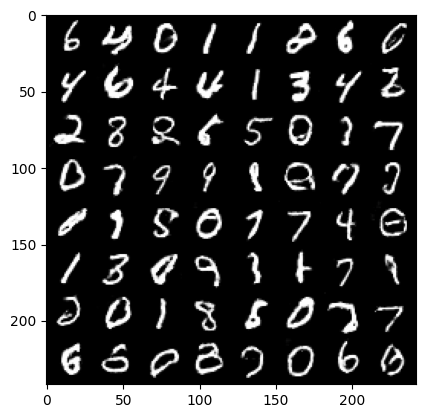

In [13]:
import matplotlib.pyplot as plt
plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)))

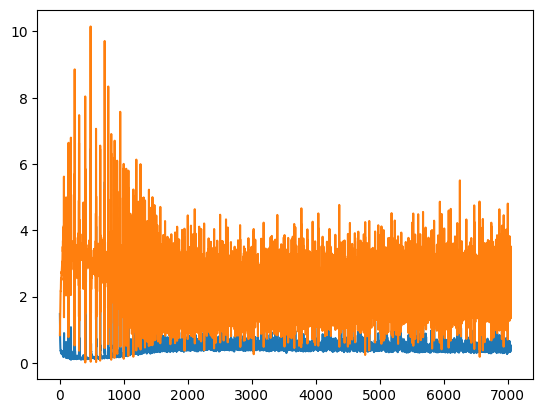

In [16]:
import matplotlib.pyplot as plt
plt.plot(D_losses)
plt.plot(G_losses)
plt.show()